### Library imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn_extra.robust import RobustWeightedRegressor
    
pd.set_option('display.max_columns', 300) # Display up to 300 columns from pandas

## TOC:
* [Loading the dataset](#dataset)
    * [Reading the dataset with pandas](#pandas)
    * [Basic EDA](#eda)
* [Regression Study](#regression)
    * [Help functions for residual computation and model definition](#help)
    * [Computation of residuals on 1 fold](#1fold)
    * [Computation of residuals on 10 folds and discussion on the evaluation metric](#10fold)
* [Annex: Selection of Hyperparameters](#annex)

## Loading the Dataset <a class="anchor" id="dataset"></a>

#### Reading the dataset with pandas <a class="anchor" id="pandas"></a>
From https://www.kaggle.com/vikasukani/forest-firearea-datasets

In [2]:
df = pd.read_csv('data/forestfires.csv', sep=',')

In [3]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
X = df[df.columns[:-1]]
y = df['area']

### Basic EDA <a class="anchor" id="eda"></a>

Target feature

(array([508.,   6.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([   0.   ,  109.084,  218.168,  327.252,  436.336,  545.42 ,
         654.504,  763.588,  872.672,  981.756, 1090.84 ]),
 <BarContainer object of 10 artists>)

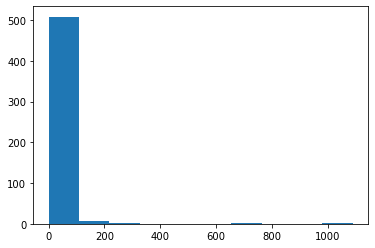

In [5]:
plt.hist(y)

The target seems to be very concentrated around $0$ with a few outlier values.

There are two categorigal features in this dataset. 

<AxesSubplot:xlabel='day', ylabel='Count'>

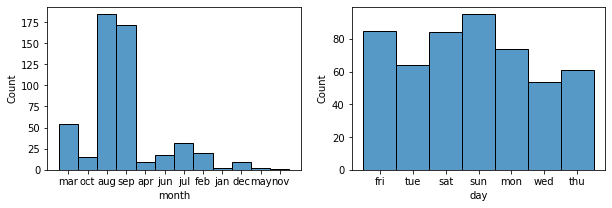

In [6]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.histplot(data=X, x="month", bins=10)
plt.subplot(1,2,2)
sns.histplot(data=X, x="day")

There is a majority of fires in August and September, it seems wise to use `month` as a feature. We also keep the feature `day`, we don't throw away any of the features.

We use One-Hot Encoding to deal with them.

In [7]:
df_month = pd.get_dummies(X.month, prefix='month')
df_day = pd.get_dummies(X.day, prefix='day')
X = pd.concat([X, df_month, df_day], axis=1)
X = X.drop(columns=['month', 'day'])

In [8]:
X.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


<AxesSubplot:>

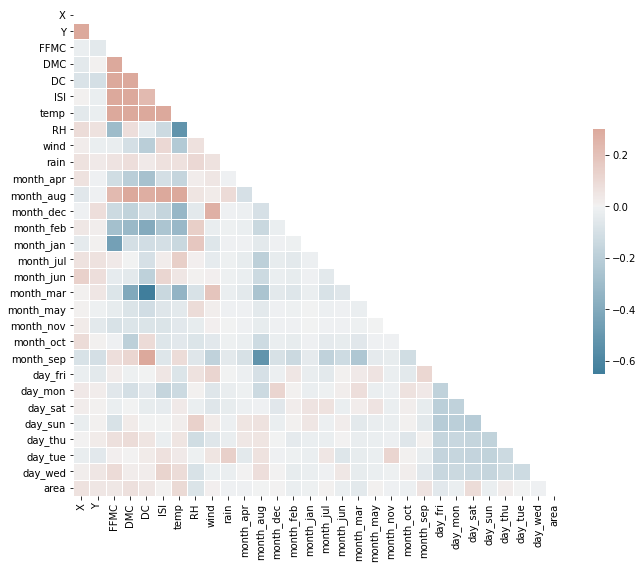

In [9]:
corr = X.assign(area = y).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There does not seem to be any one feature that is particularly highly correlated with area. We keep all the features.

## Regression Study <a class="anchor" id="regression"></a>

### Help functions for residual computation and model definition <a class="anchor" id="help"></a>

In [10]:
def get_resid(reg, name, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=random_state)
    reg.fit(X_train, y_train)
    return pd.DataFrame({'residuals': np.abs(reg.predict(X_test)-y_test), 
                            'name': name})

Definition of estimators.


In [11]:
ols = LinearRegression()
rf = RandomForestRegressor(criterion='mae', max_depth=5, n_estimators=50)
huber_reg = Pipeline(steps=[('scaler', RobustScaler()),
                            ('reg',HuberRegressor(epsilon=1.0))])
ts = TheilSenRegressor()
svm = SVR(C=0.01)


scikit-learn-extra estimators use SGDRegressor as base estimator hence we need to scale the data.
Being in a Robust Framework, we use RobustScaler.

In [12]:
RWE_huber = Pipeline([('scaler',RobustScaler()), 
                      ('reg',RobustWeightedRegressor(burn_in=0, loss='huber'))])
RWE_mom = Pipeline(steps=[('scaler', RobustScaler()),
                ('reg', RobustWeightedRegressor(k=5, loss='huber',burn_in=0, 
                                                weighting='mom'))])

In [13]:
names=['OLS', 'TheilSen', 'SVM', 'RF', 'Huber', 'RWE_Huber', 'RWE_MoM'] # names of estimators

### Computation of residuals on 1 fold. <a class="anchor" id="1fold"></a>

In [14]:
residuals_lr = get_resid(ols, 'OLS', 42)
residuals_huber = get_resid(huber_reg, 'Huber', 42)
residuals_theil = get_resid(ts, 'TheilSen', 42)
residuals_rf = get_resid(rf, 'RF', 42)
residuals_svm = get_resid(svm, 'SVM', 42)
residuals_rwe_hub = get_resid(RWE_huber, 'RWE_Huber', 42)
residuals_rwe_mom = get_resid(RWE_mom, 'RWE_MoM', 42)


residuals = pd.concat([residuals_lr, residuals_theil,residuals_rf,residuals_huber, 
                       residuals_rwe_hub, residuals_rwe_mom, residuals_svm])

/usr/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(-0.5, 30.0)

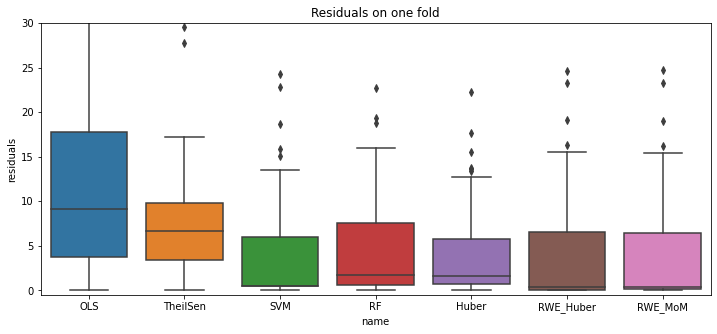

In [15]:
plt.figure(figsize=(12,5))
sns.boxplot(data = residuals, x='name', y='residuals', order=names)
plt.title("Residuals on one fold")
plt.ylim(-0.5,30)

### Computation of residuals on 10 folds and discussion on the evaluation metric <a class="anchor" id="10fold"></a>

In [16]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

**Warning**: I disabled convergence warning. HuberRegressor do not converge and I didn't succeed in making it convergent, but I disabled the warnings to avoid cluttered output.

In [17]:

folds = 10
results = []

for f in range(folds) :
    residuals_lr = get_resid(ols, 'OLS', f)
    residuals_huber = get_resid(huber_reg, 'Huber', f)
    residuals_theil = get_resid(ts, 'TheilSen', f)
    residuals_rf = get_resid(rf, 'RF', f)
    residuals_svm = get_resid(svm, 'SVM', f)
    residuals_rwe_hub = get_resid(RWE_huber, 'RWE_Huber', f)
    residuals_rwe_mom = get_resid(RWE_mom, 'RWE_MoM', f)


    residuals = pd.concat([residuals_lr, residuals_theil,residuals_rf,residuals_huber, 
                       residuals_rwe_hub, residuals_rwe_mom, residuals_svm])
    results += [residuals.groupby(['name']).residuals.agg(['mean', 'median'])]

In [18]:
results = pd.concat([res.reset_index() for res in results])

In [19]:
results.head()

,name,mean,median
0,Huber,22.884708,1.741308
1,OLS,26.267418,9.038831
2,RF,23.040344,1.819200
3,RWE_Huber,22.779716,1.443106
4,RWE_MoM,22.759532,1.277189


In [20]:
results = results.melt(id_vars=["name"], 
        var_name="Statistic", 
        value_name="Value")

(-0.5, 25.0)

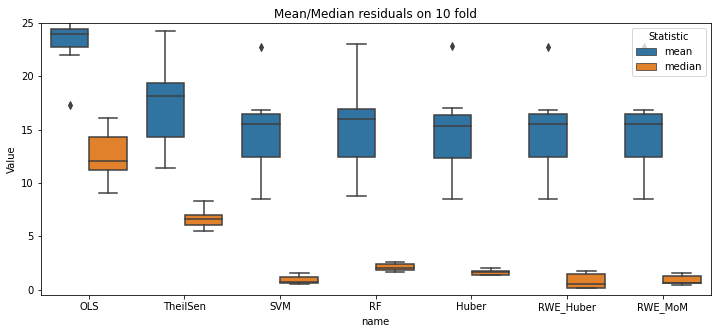

In [21]:
plt.figure(figsize=(12,5))
sns.boxplot(data = results, x='name', y='Value',hue="Statistic", order=names)
plt.title("Mean/Median residuals on 10 fold")
plt.ylim(-0.5,25)

The mean values are hard to differentiate but the median values are better to choose one model compared to another one.

(-0.5, 15.0)

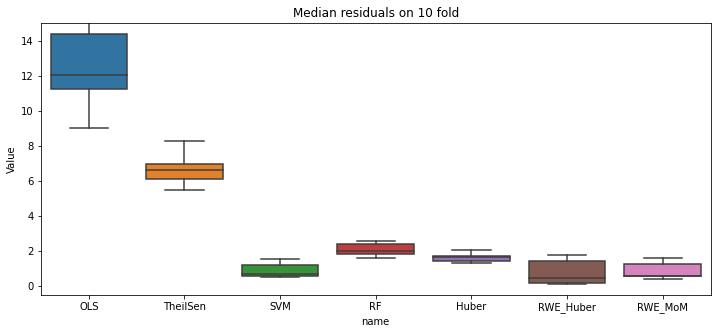

In [22]:
plt.figure(figsize=(12,5))
sns.boxplot(data = results.loc[results.Statistic == 'median'], 
            x='name', y='Value', order=names)
plt.title("Median residuals on 10 fold")
plt.ylim(-0.5,15)

The winner seems to be either SVM or RWE estimators. 

The deficiencies of HuberRegressor are likely due to optimization problems as indicated by the convergence errors displayed during training.

## Annex : Selection of Hyperparameters <a class="anchor" id="annex"></a>

In [22]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10, 100]}
svr = SVR()
clf = GridSearchCV(svr, parameters,scoring='neg_median_absolute_error', cv=10)
clf.fit(X, y)
clf.best_estimator_

SVR(C=0.1)

In [23]:
parameters = {'n_estimators':[50,100,200], 
              'max_depth':[None,5, 10], 
              'criterion':['mse', 'mae']}
rf = RandomForestRegressor()
clf = GridSearchCV(rf, parameters,scoring='neg_median_absolute_error', cv=10)
clf.fit(X, y)
clf.best_estimator_

RandomForestRegressor(criterion='mae', max_depth=5)

In [24]:
parameters = {'reg__c':[ 1e-4, 1e-3,1e-2,1e-1,1,5,10,50,None], 
              'reg__loss':['huber', "squared_loss"],
              'reg__burn_in':[0, 10]
             }
reg = RWE_huber = Pipeline([('scaler',RobustScaler()), 
                      ('reg',RobustWeightedRegressor())])
clf = GridSearchCV(reg, parameters,scoring='neg_median_absolute_error', cv=10)
clf.fit(X, y)
clf.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('reg', RobustWeightedRegressor(c=1, loss='huber'))])

In [25]:
parameters = {'reg__k':[1,2,3,4,5, None], 
              'reg__weighting':['mom'],
              'reg__loss':['huber', "squared_loss"],
              'reg__burn_in':[0, 10]
             }
reg = RWE_MoM = Pipeline([('scaler',RobustScaler()), 
                      ('reg',RobustWeightedRegressor())])
clf = GridSearchCV(reg, parameters,scoring='neg_median_absolute_error', cv=10)
clf.fit(X, y)
clf.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('reg',
                 RobustWeightedRegressor(burn_in=0, k=5, loss='huber',
                                         weighting='mom'))])

In [26]:
parameters = {'epsilon':[1.0, 1.5, 2.0, 5.0], 
              'alpha':[1e-4, 1e-3, 1e-2, 1e-1],
              'max_iter':[100,200]
             }
reg = HuberRegressor()
clf = GridSearchCV(reg, parameters,scoring='neg_median_absolute_error', cv=10)
clf.fit(X, y)
clf.best_estimator_

HuberRegressor(epsilon=1.0)